In [1]:
from IPython.display import Image
import ee
import ee.mapclient
import datetime

ee.Initialize()
L1_AGBPSeasonals = ee.ImageCollection("projects/fao-wapor/L1_AGBP")
ETaCollection = ee.ImageCollection("projects/fao-wapor/L1_AET")
AET250 = ee.ImageCollection("users/lpeiserfao/AET250")

rasterSeason1 = ee.Image(L1_AGBPSeasonals.first())

# Informazioni varie sui dati di input

In [2]:
rasterSeason1.getInfo()

{u'bands': [{u'crs': u'EPSG:4326',
   u'crs_transform': [0.00223214286,
    0.0,
    -30.0044643,
    0.0,
    -0.00223214286,
    40.0044643],
   u'data_type': {u'precision': u'float', u'type': u'PixelType'},
   u'dimensions': [42564, 35844],
   u'id': u'b1'}],
 u'id': u'projects/fao-wapor/L1_AGBP/L1_AGBP_15s1',
 u'properties': {u'area': u'AfNE',
  u'days_in_dk': 0.0,
  u'season': 1.0,
  u'system:asset_size': 1602581313,
  u'system:footprint': {u'coordinates': [[33.45815610768672,
     40.00558428068579],
    [23.809038489303575, 40.00558428068579],
    [9.335362061737218, 40.00558428068581],
    [-1.0559953734367642, 40.005584280685795],
    [-14.78743198420065, 40.005584280685795],
    [-30.00626732411657, 40.005579588766935],
    [-30.00626732411973, -40.00557966260693],
    [-18.127511159796093, -40.00558435452578],
    [0.057364351758189706, -40.00558435452578],
    [13.788800962527548, -40.00558435452578],
    [33.82927601608015, -40.00558435452579],
    [51.27191171084418, -40.

In [3]:
coordinate = rasterSeason1.get('system:footprint')
coordinate.getInfo()

{u'coordinates': [[33.45815610768672, 40.00558428068579],
  [23.809038489303575, 40.00558428068579],
  [9.335362061737218, 40.00558428068581],
  [-1.0559953734367642, 40.005584280685795],
  [-14.78743198420065, 40.005584280685795],
  [-30.00626732411657, 40.005579588766935],
  [-30.00626732411973, -40.00557966260693],
  [-18.127511159796093, -40.00558435452578],
  [0.057364351758189706, -40.00558435452578],
  [13.788800962527548, -40.00558435452578],
  [33.82927601608015, -40.00558435452579],
  [51.27191171084418, -40.00558435452578],
  [65.0062674171597, -40.00557966260692],
  [65.00626741715656, 40.00557958876695],
  [54.240870978035474, 40.005584280685795],
  [44.220633451257086, 40.00558428068579],
  [33.45815610768672, 40.00558428068579]],
 u'type': u'LinearRing'}

In [4]:
illo = rasterSeason1.get('system:index'),2
type(illo)

tuple

In [5]:
index = rasterSeason1.get('system:index')
index.getInfo()

u'L1_AGBP_15s1'

In [6]:
bande = rasterSeason1.bandNames()
bande.getInfo()

[u'b1']

In [7]:
region = [[-25.0, -37.0], [60.0, -41.0], [58.0, 39.0], [-31.0, 38.0], [-25.0, -37.0]]

# Inizio calcolo WP

### Above Ground Biomass Production with masked NoData (pixel < 0) and summed

In [8]:
L1_AGBPSeasonalMasked =L1_AGBPSeasonals.map(lambda lista: lista.updateMask(lista.gte(0)))

#the multiplier will need to be applied on net FRAME delivery, not on sample dataset
L1_AGBPSummedYearly = L1_AGBPSeasonalMasked.sum(); #.multiply(10); 

### Actual Evapotranspiration with valid ETa values (>0 and <254)

In [9]:
ETaColl1 = AET250.map(lambda immagine: immagine.updateMask(immagine.lt(254) and (immagine.gt(0)))) 

### add image property (days in dekad) as band

In [10]:
ETaColl2 = ETaColl1.map(lambda immagine: immagine.addBands(immagine.metadata('days_in_dk')));

### get ET value, divide by 10 (as per FRAME spec) to get daily value, and multiply by number of days in dekad summed annually

In [11]:
ETaColl3 = ETaColl2.map(lambda immagine: immagine.select('b1').divide(10).multiply(immagine.select('days_in_dk'))).sum()

### scale ETsum from mm/m² to m³/ha for WP calculation purposes

In [12]:
ETaTotm3 = ETaColl3.multiply(10)

### calculate biomass water productivity and add to map

In [13]:
WPbm = L1_AGBPSummedYearly.divide(ETaTotm3)
WPbm.getInfo()

{u'bands': [{u'crs': u'EPSG:4326',
   u'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
   u'data_type': {u'precision': u'double', u'type': u'PixelType'},
   u'id': u'b1'}],
 u'type': u'Image'}

In [14]:
region = [[-25.0, -37.0], [60.0, -41.0], [58.0, 39.0], [-31.0, 38.0], [-25.0, -37.0]]
scala = WPbm.projection().nominalScale().getInfo()

visparams = {"opacity":1,
             "min":0,
             "max":1.2,
             "palette":"bc170f,e97a1a,fff83a,9bff40,5cb326",
             "region":region,
             "scale" : scala}

In [15]:
url_WPbm = WPbm.getThumbUrl(visparams)
Image(url=url_WPbm)

In [16]:
url_WPbm

u'https://earthengine.googleapis.com/api/thumb?thumbid=ca7e0513f35ed349ace23502091ac682&token=77c99d49fc2e96fa86666a1e21b193d0'

In [18]:
import matplotlib.pyplot as plt
imag_WPbm = plt.imread(url_WPbm)
plt.imshow(imag_WPbm)

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [19]:
%matplotlib qt

In [20]:
a = plt.imread(url_WPbm)
plt.imshow(a)

In [ ]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
plt.imshow(a)
plt.show()

In [ ]:
import mpld3
mpld3.enable_notebook()

In [ ]:
plt.imshow(a)

In [ ]:
downConfig = {'scale': scala,
              'maxPixels' : 1500000000,
              'region': region};

fileName = 'WP_py'
export = ee.batch.Export.image(WPbm, fileName,downConfig);
#export.start();

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

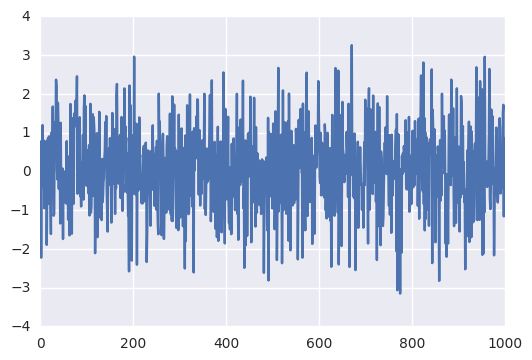

In [41]:
y = np.random.randn(1000)
plt.plot(y)

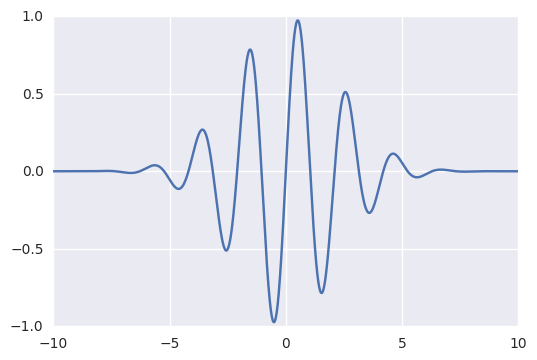

In [42]:
x = np.linspace(-10., 10., 1000)
y = np.sin(3 * x) * np.exp(-.1 * x**2)
plt.plot(x, y)

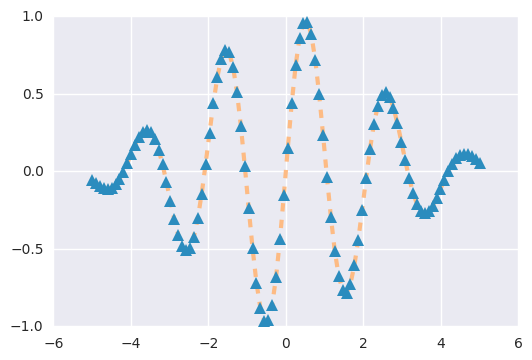

In [43]:
x = np.linspace(-5., 5., 100)
y = np.sin(3 * x) * np.exp(-.1 * x ** 2)
plt.plot(x, y, '--^',
lw=3, color='#fdbb84',
mfc='#2b8cbe', ms=8)

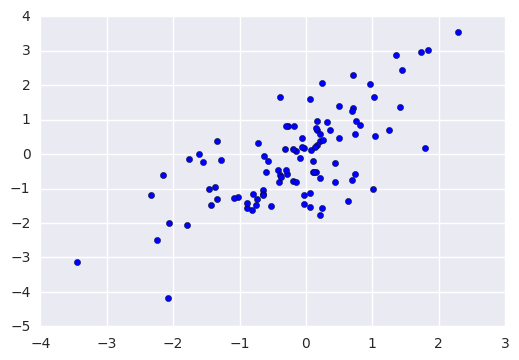

In [45]:
x = np.random.randn(100)
y = x + np.random.randn(100)
plt.scatter(x, y)

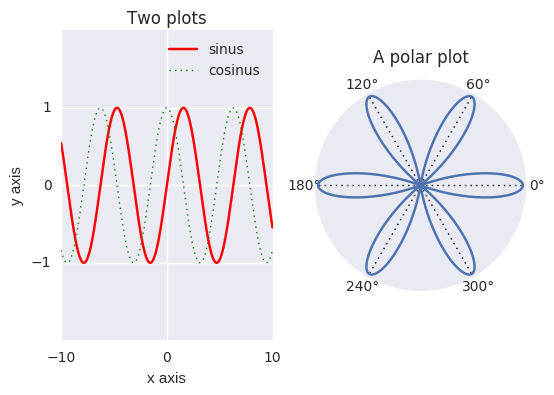

In [46]:
# Left panel.
plt.subplot(1, 2, 1)
x = np.linspace(-10., 10., 1000)
plt.plot(x, np.sin(x), '-r', label='sinus')
plt.plot(x, np.cos(x), ':g', lw=1, label='cosinus')
plt.xticks([-10, 0, 10])
plt.yticks([-1, 0, 1])
plt.ylim(-2, 2)
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.title("Two plots")
plt.legend()
# Right panel.
plt.subplot(1, 2, 2, polar=True)
x = np.linspace(0, 2 * np.pi, 1000)
plt.plot(x, 1 + 2 * np.cos(6 * x))
plt.yticks([])
plt.xlim(-.1, 3.1)
plt.ylim(-.1, 3.1)
plt.xticks(np.linspace(0, 5 * np.pi / 3, 6))
plt.title("A polar plot")
plt.grid(color='k', linewidth=1, linestyle=':')

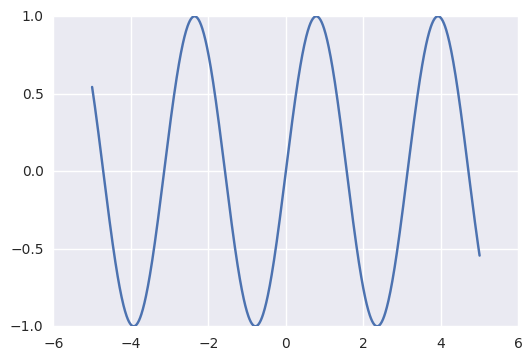

In [48]:
from ipywidgets import interact
x = np.linspace(-5., 5., 1000)

@interact
def plot_sin(a=(1, 10)):
    plt.plot(x, np.sin(a*x))
    plt.ylim(-1, 1)

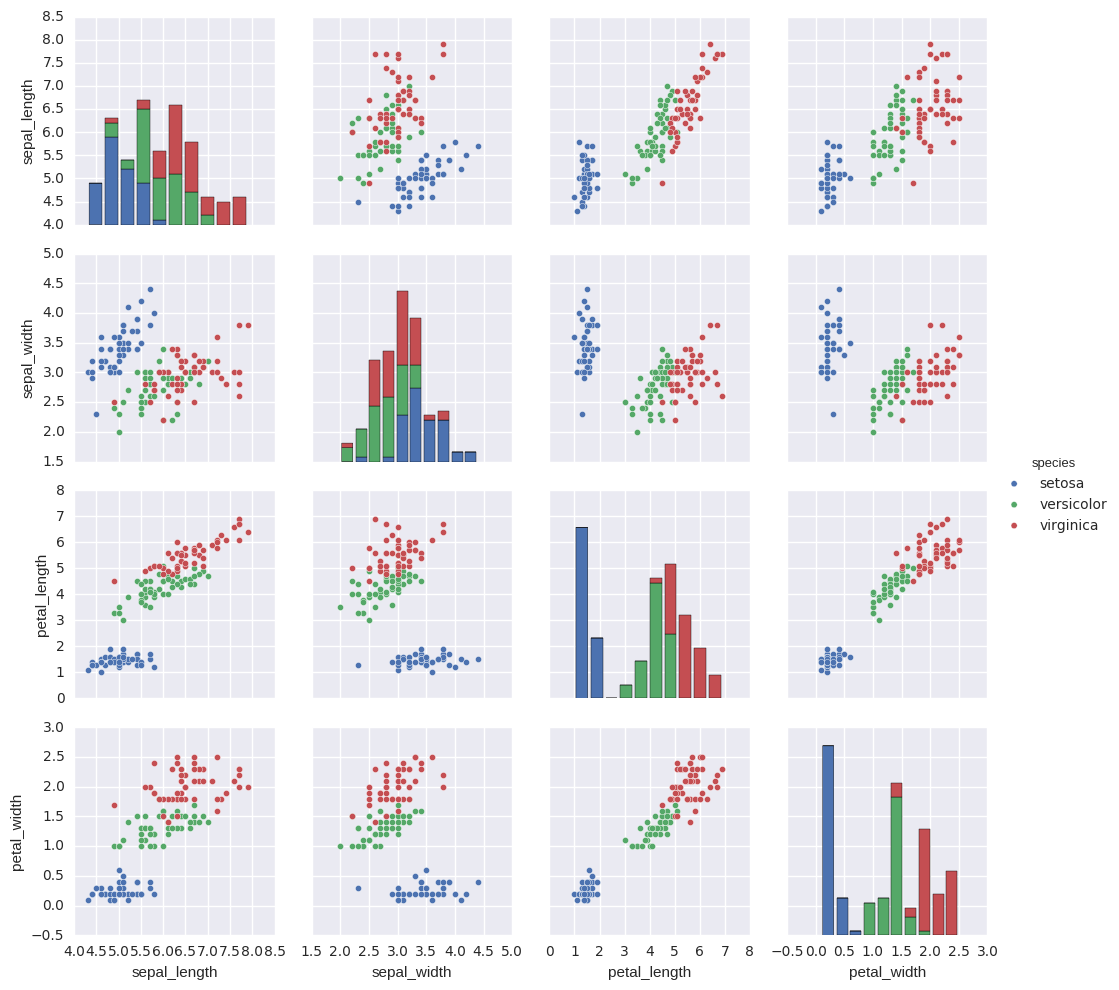

In [57]:
#%matplotlib qt
%matplotlib inline
df = seaborn.load_dataset("iris")
seaborn.pairplot(df, hue="species", size=2.5)

In [59]:
import numpy as np
import skimage
from skimage import img_as_float
import skimage.filters as skif
from skimage.color import rgb2gray
import skimage.data as skid
import skimage.exposure as skie
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [61]:
chelsea = skid.chelsea()
chelsea.shape, chelsea.dtype

((300, 451, 3), dtype('uint8'))

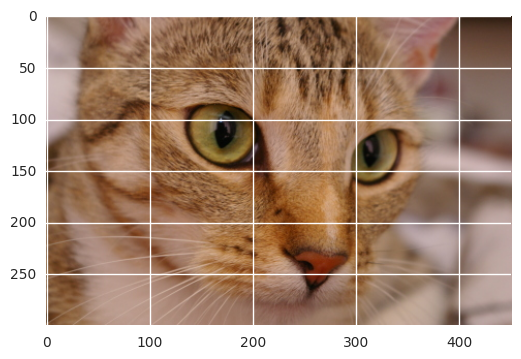

In [62]:
plt.imshow(chelsea)

(0.0, 1.0, 0.0, 1.0)

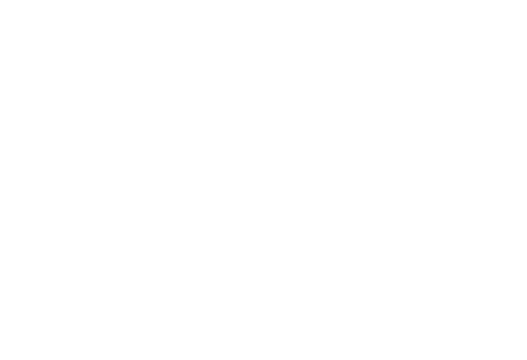

In [66]:
plt.axis('off')

In [68]:
img = rgb2gray(chelsea)
img.shape, img.dtype
#img

((300, 451), dtype('float64'))

In [69]:
p2, p98 = np.percentile(img, (2, 98))

In [70]:
img_rescale = skie.rescale_intensity(img, in_range=(p2, p98))

In [71]:
img_eq = skie.equalize_hist(img)

In [73]:
img_adapteq = img_as_float(skie.equalize_adapthist(img, clip_limit=0.03))

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [74]:
hist_types = dict([('Contrast stretching', img_rescale),
('Histogram equalization', img_eq),
('Adaptive equalization', img_adapteq)])

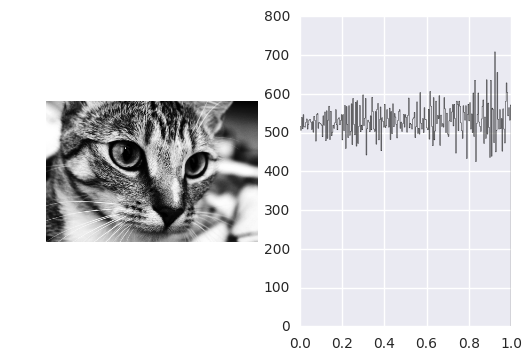

In [76]:
@interact(hist_type=list(hist_types.keys()))
def display_result(hist_type):
    result = hist_types[hist_type]
    # We display the processed grayscale image on the left.
    plt.subplot(121)
    plt.imshow(result, cmap='gray')
    plt.axis('off')

    # We display the histogram on the right.
    plt.subplot(122)
    plt.hist(result.ravel(), bins=np.linspace(0., 1., 256),
    histtype='step', color='black')
    plt.show()

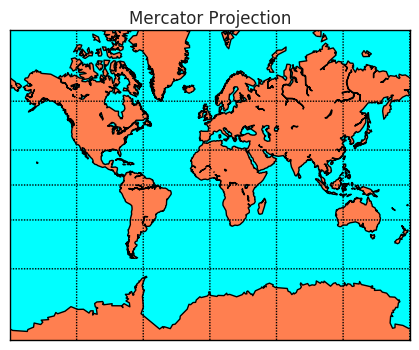

In [78]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')
plt.title("Mercator Projection")
plt.show()